# PCA, PCoA, PERMANOVA

**Getting further into multivariate analysis**:

The [GUSTA ME website](https://mb3is.megx.net/gustame) contains descriptions of many multivariate analyses aimed at microbial ecologists using R.

In [1]:
# Load packages
library(ggplot2) # Plotting
library(phyloseq)
library(vegan) # PERMANOVA

Indlæser krævet pakke: permute

Indlæser krævet pakke: lattice

This is vegan 2.5-7



# Example datasets<a class="anchor" id="data"></a>
**iris:** Data on Iris plant characteristics. A data.frame

In [2]:
data(iris)
head(iris)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa


**phy:** Our simulated gut microbiome dataset. A phyloseq object

In [3]:
load("../data/physeq.RData")
phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1310 taxa and 150 samples ]
sample_data() Sample Data:       [ 150 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 1310 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1310 tips and 1309 internal nodes ]
refseq()      DNAStringSet:      [ 1310 reference sequences ]

## PCA <a class="anchor" id="pca"></a>
How would you display 4 axes on a graph? What about 1000 axes? Microbiome datasets are high-dimensional, with maybe hundreds of samples and thousands of taxa. But we use 2-dimensional screens and paper, which limits our view of this data.
Principle component analysis (PCA) is a way of projecting your high-dimensional data into lower dimensions. While this sounds obscure, it is extremely powerful. Imagine a dataset with 20 samples and 1000 variables (e.g. ASVs), how would you make a plot showing whether your samples are different? PCA transforms the data, and creates new axes (known as principle components (PCs)), these PCs are created such that PC1 spans as much variation as posssible in the dataset, PC2 spans as much variance as possible while being orthogonal (90 degree angle) to PC1, PC3 spans as much variance as possible while being orthogonal to PC1 and PC2, and so on.

The output from running a PCA is:
* The PCs, the new axes
* Eigenvalues for each PC, which denote how much variation each PC span
* Loadings (Eigenvectors): How much does each variable contribute to each PC

Is it still confusing?:
* [Read the first answer to this Stack Exchange question](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues/140579#140579)
* [or read this excellent article](https://www.nature.com/articles/nmeth.4346)


**In R:**

Let's run a PCA on the plant data, plot the first two axes, and color the points by the plant species 

In [4]:
# We only use the first 4 columns
iris_sub <- iris[, 1:4]
# Always set center and scale. to TRUE
pca <- prcomp(iris_sub, center=TRUE, scale.=TRUE)

In [5]:
str(pca)
# pca$sdev contains the standard deviation of the PCs (used to calculate eigenvalues and thereby variance explained)
# pca$x contains the PCs
# pca$rotation contains loadings: How much the original variables contribute to each PC

List of 5
 $ sdev    : num [1:4] 1.708 0.956 0.383 0.144
 $ rotation: num [1:4, 1:4] 0.521 -0.269 0.58 0.565 -0.377 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:4] "Sepal.Length" "Sepal.Width" "Petal.Length" "Petal.Width"
  .. ..$ : chr [1:4] "PC1" "PC2" "PC3" "PC4"
 $ center  : Named num [1:4] 5.84 3.06 3.76 1.2
  ..- attr(*, "names")= chr [1:4] "Sepal.Length" "Sepal.Width" "Petal.Length" "Petal.Width"
 $ scale   : Named num [1:4] 0.828 0.436 1.765 0.762
  ..- attr(*, "names")= chr [1:4] "Sepal.Length" "Sepal.Width" "Petal.Length" "Petal.Width"
 $ x       : num [1:150, 1:4] -2.26 -2.07 -2.36 -2.29 -2.38 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:4] "PC1" "PC2" "PC3" "PC4"
 - attr(*, "class")= chr "prcomp"


In [6]:
# Turn new columns into a dataframe
pc_df <- data.frame(pca$x)
# Add the species column
pc_df$Species <- iris$Species

Now the dataframe looks like this:

In [7]:
head(pc_df)

,PC1,PC2,PC3,PC4,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,-2.257141,-0.4784238,0.12727962,0.024087508,setosa
2,-2.074013,0.6718827,0.23382552,0.102662845,setosa
3,-2.356335,0.3407664,-0.04405390,0.028282305,setosa
4,-2.291707,0.5953999,-0.09098530,-0.065735340,setosa
5,-2.381863,-0.6446757,-0.01568565,-0.035802870,setosa
6,-2.068701,-1.4842053,-0.02687825,0.006586116,setosa


We can only get as many PCs as we have samples or variables, whichever is lowest.

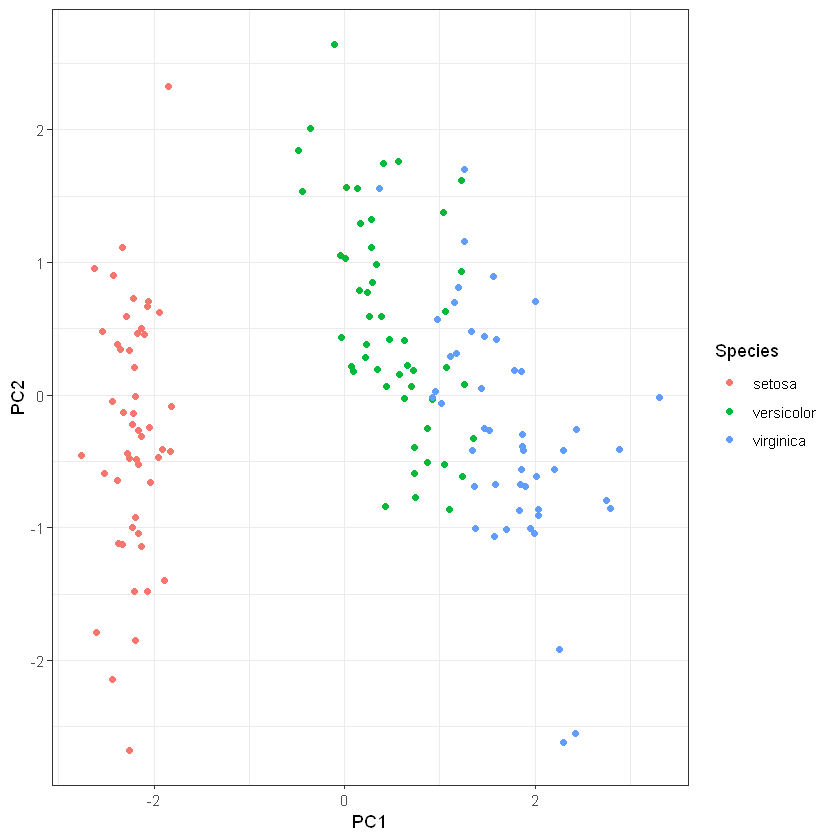

In [8]:
# Plot it
p <- ggplot(pc_df, aes(x = PC1, y = PC2, color = Species)) +
    theme_bw() +
    geom_point()
p

Let's look at which variables drive the PCs (loadings). 

In [9]:
pca$rotation

,PC1,PC2,PC3,PC4
Sepal.Length,0.5210659,-0.37741762,0.7195664,0.2612863
Sepal.Width,-0.2693474,-0.92329566,-0.2443818,-0.1235096
Petal.Length,0.5804131,-0.02449161,-0.1421264,-0.8014492
Petal.Width,0.5648565,-0.06694199,-0.6342727,0.5235971


PC1 is mostly a combination of Sepal.Length, Petal.Length, and Petal.Width. PC2 is mostly driven by Sepal.Width.

We can get the eigenvalues from the sdev:

In [10]:
eigen <- pca$sdev^2
eigen

[1] 2.91849782 0.91403047 0.14675688 0.02071484

From the eigenvalues we can get the variance explained:

In [11]:
ve <- eigen/sum(eigen)
ve

[1] 0.729624454 0.228507618 0.036689219 0.005178709

We can put this on the plot

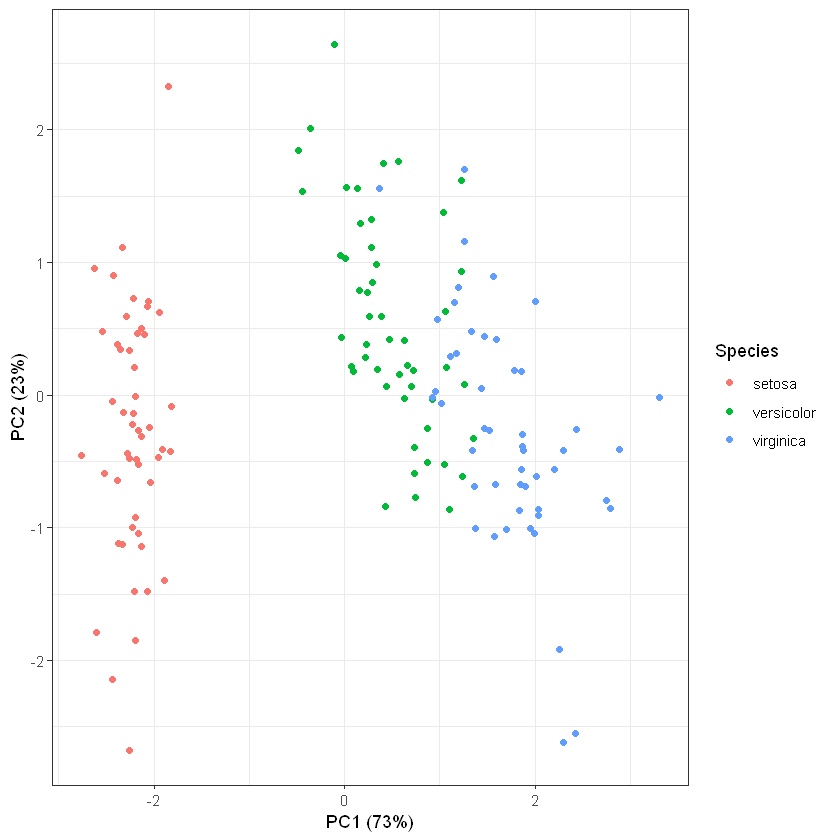

In [12]:
p + 
    xlab(paste0("PC1 (", round(100*ve[1]), "%)")) +
    ylab(paste0("PC2 (", round(100*ve[2]), "%)"))

## PCoA<a class="anchor" id="pcoa"></a>
PCA is based on linear combinations of the variables, and therefore assumes that data is not too skewed, and relatively normally distributed. Principle Coordinate Analysis (PCoA) is a generalized version of PCA. The input is a dissimilarity matrix. If this dissimilarity matrix is based on euclidean distances between samples, the PCs are the same as the PCA. The strength with PCoA is that we can use any dissimilarity metric as input. Various dissimilarity metrics appropriate for amplicon data are explained in the [Beta diversity notebook](https://microucph.github.io/amplicon_data_analysis/html/beta.html).

**Note on R code:**

There are multiple different functions for calculating PCoA in R. The code presented below is different than what you would usually use when the input is an amplicon dataset (in a phyloseq object). Therefore, when you have a phyloseq object use the code presented in the [beta diversity notebook](https://microucph.github.io/amplicon_data_analysis/html/beta.html). The code below is used if your input is a data.frame with observations as rows and variables as columns. If you want to use the code below on an amplicon dataset you would substitute iris_sub with for example t(otu_table(phy)) - The t() transposes the abundance table and is only necessary if taxa_are_rows(phy) returns TRUE.

**In R:**

Let's calculate the Bray-Curtis distance between samples, and then plot a PCoA

In [13]:
library(vegan)
dd <- vegdist(iris_sub, method = "bray")

Have a look at the dissimilarity matrix (only 5 first samples). Each value is the dissimilarity between a pair of samples. The diagonal is the dissimilarity between the same samples, and is, as expected, equal to zero. 

In [14]:
as.matrix(dd)[1:5,1:5]

,1,2,3,4,5
1,0.000000000,0.03553299,0.04081633,0.05102041,0.009803922
2,0.035532995,0.00000000,0.02645503,0.02645503,0.035532995
3,0.040816327,0.02645503,0.00000000,0.02127660,0.040816327
4,0.051020408,0.02645503,0.02127660,0.00000000,0.051020408
5,0.009803922,0.03553299,0.04081633,0.05102041,0.000000000


In [15]:
# PCoA
pcoa_data <- cmdscale(dd, eig = TRUE)

# Collect in data.frame
pcoa_df <- data.frame(PC1 = c(pcoa_data$points[,1]),
                      PC2 = c(pcoa_data$points[,2]),
                      Species = iris$Species)

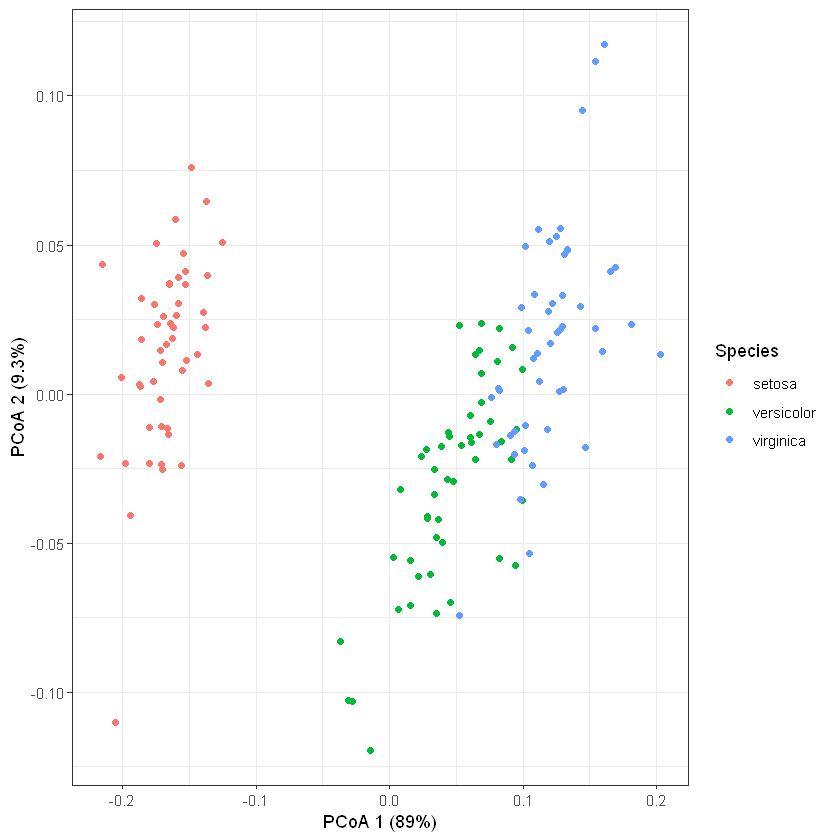

In [16]:
# Variance explained
ve <- pcoa_data$eig/sum(pcoa_data$eig)

# Plot it
p <- ggplot(pcoa_df, aes(x = PC1, y = PC2, color = Species)) +
    theme_bw() +
    geom_point() +
    xlab(paste0("PCoA 1 (",round(ve[1]*100,1),"%)")) +
    ylab(paste0("PCoA 2 (",round(ve[2]*100,1),"%)"))
p

## PERMANOVA <a class="anchor" id="permanova"></a>
PERmutational Multivariate ANalysis Of VAriance (PERMANOVA) is a method to estimate the effect a variable has on the entire microbial community. For example, for our gut microbiome dataset, we could ask whether the microbial community is different at different time points. PERMANOVA does not tell us HOW the microbial communities differ; if we want to know specifically which taxa are different between different time points we would run a Differential Abundance analysis ([see notebook on this topic](https://microucph.github.io/amplicon_data_analysis/html/da.html)).

The input to PERMANOVA is a dissimilarity matrix. The results of the PERMANOVA is therefore very contingent on the dissimilarity metric that is used.

**Note:** The p-values are calculated by permutation, which is a random process, and will therefore vary a little each time you run it.

**In R:**

In [17]:
# Calculate unweighted UniFrac (our dissimilarity matrix)
UF <- UniFrac(phy, weighted = FALSE)

# Extract sample data
Samp <- data.frame(sample_data(phy))

# We use the adonis function from the vegan package to run PERMANOVA
adonis(UF ~ Time, data = Samp)


Call:
adonis(formula = UF ~ Time, data = Samp) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Time        2     7.154  3.5770  21.224 0.22406  0.001 ***
Residuals 147    24.774  0.1685         0.77594           
Total     149    31.929                 1.00000           
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

We can see that *Time* has a significant effect (P-value = 0.001) on the microbial community (as summarized by unweighted UniFrac). The variance explained (R2) by the *Time* variable is 22.4%.

#### Add additional variables:
Here we add Delivery

In [18]:
adonis(UF ~ Time + Delivery, data = Samp)


Call:
adonis(formula = UF ~ Time + Delivery, data = Samp) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Time        2     7.154  3.5770 21.5865 0.22406  0.001 ***
Delivery    1     0.581  0.5813  3.5081 0.01821  0.001 ***
Residuals 146    24.193  0.1657         0.75773           
Total     149    31.929                 1.00000           
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

#### Add interactions between variables
For example, here we test whether the effect of Delivery changes depending on the time point, or vice versa (Time:Delivery).

In [19]:
adonis(UF ~ Time * Delivery, data = Samp)


Call:
adonis(formula = UF ~ Time * Delivery, data = Samp) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

               Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Time            2     7.154  3.5770 22.1480 0.22406  0.001 ***
Delivery        1     0.581  0.5813  3.5993 0.01821  0.001 ***
Time:Delivery   2     0.936  0.4682  2.8988 0.02933  0.001 ***
Residuals     144    23.257  0.1615         0.72840           
Total         149    31.929                 1.00000           
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In this last model we see that Time has a significant effect explaining 22.4% of the variance. Delivery mode also has a significant effect explaining 1.8% of the variance. Furthermore, there is a significant interaction between Time and Delivery explaining 2.9% of the variance. That there is an interaction means that the two variables are not having indepedent effects on the UniFrac dissimilariy. In other words, the effect of Delivery is dependent on the Time variable, and vice versa. This is probably because there is a large effect of delivery in the early time points, but small in the later time point. One could test this by running a PERMANOVA testing the effect of delivery separately for each time point. 